# Задача.

Дан датасет прослушиваний музыки, который нужно скачать по [ссылке](https://www.kaggle.com/competitions/kkbox-music-recommendation-challenge/data) (описание данных можно найти там же).

На основе этих данных построить рекомендательную систему релевантных треков для пользователей и оценить ее качество. В качестве метрики качества используйте NDSG@20.

# Содержание файла.

1) Exploratory data analysis.

2) Выбор модели для рекомендательной системы музыки.

3) Подготовка данных для модели.

4) Разработка модели.

5) Подбор параметров модели.

6) Финальная оценка качества модели с помощью метрики NDSG@20.

# Exploratory data analysis.

Добавим необходимые библиотеки.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse.linalg import svds
from scipy import sparse

from sklearn.metrics import ndcg_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import opendatasets as od
import py7zr
import glob

Скачаем датасет с сайта Kaggle.

In [4]:
od.download('https://www.kaggle.com/competitions/kkbox-music-recommendation-challenge/data')

Skipping, found downloaded files in ".\kkbox-music-recommendation-challenge" (use force=True to force download)


Распакуем файлы.

In [5]:
for file in glob.glob('kkbox-music-recommendation-challenge/*.7z'):
    with py7zr.SevenZipFile(file, mode='r') as z:
        z.extractall(path='kkbox-music-recommendation-challenge/')

Посмотрим какие файлы у нас есть.

In [6]:
for file in glob.glob('kkbox-music-recommendation-challenge/*.csv'):
    print(file)

kkbox-music-recommendation-challenge\members.csv
kkbox-music-recommendation-challenge\sample_submission.csv
kkbox-music-recommendation-challenge\songs.csv
kkbox-music-recommendation-challenge\song_extra_info.csv
kkbox-music-recommendation-challenge\test.csv
kkbox-music-recommendation-challenge\train.csv


Загрузим данные из файлов в датафреймы Pandas.

In [7]:
df_members = pd.read_csv('kkbox-music-recommendation-challenge/members.csv')
df_sample_submission = pd.read_csv('kkbox-music-recommendation-challenge/sample_submission.csv')
df_song_extra_info = pd.read_csv('kkbox-music-recommendation-challenge/songs.csv')
df_songs = pd.read_csv('kkbox-music-recommendation-challenge/song_extra_info.csv')
df_test = pd.read_csv('kkbox-music-recommendation-challenge/test.csv')
df_train = pd.read_csv('kkbox-music-recommendation-challenge/train.csv')

Посмотрим на полученные датафреймы.

In [8]:
print(df_members.shape)
df_members.head(5)

(34403, 7)


,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [9]:
print(df_sample_submission.shape)
df_sample_submission.head(5)

(2556790, 2)


,id,target
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [10]:
print(df_song_extra_info.shape)
df_song_extra_info.head(5)

(2296320, 7)


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [11]:
print(df_songs.shape)
df_songs.head(5)

(2295971, 3)


,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [12]:
print(df_test.shape)
df_test.head(5)

(2556790, 6)


,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [13]:
print(df_train.shape)
df_train.head(5)

(7377418, 6)


,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


Дополним датафрейм df_train информацией из df_members, df_song_extra_info, df_songs.

In [14]:
df_fulldata = pd.merge(df_train, df_members, on='msno', how='left')
df_fulldata = pd.merge(df_fulldata, df_song_extra_info, on='song_id', how='left')
df_fulldata = pd.merge(df_fulldata, df_songs, on='song_id', how='left')

Далее будем работать только с датафреймом df_fulldata, т.к. он содержит в себе всю необходимую информацию

In [15]:
del df_members
del df_sample_submission
del df_song_extra_info
del df_songs
del df_test
del df_train

Для удобства применим label encoding к столбцам msno и song_id.

In [16]:
le_msno = LabelEncoder()
le_song_id = LabelEncoder()
le_msno.fit(df_fulldata['msno'])
le_song_id.fit(df_fulldata['song_id'])

df_fulldata['msno'] = le_msno.fit_transform(df_fulldata['msno'])
df_fulldata['song_id'] = le_song_id.fit_transform(df_fulldata['song_id'])

Разобъём столбцы с датами на столбцы с годом, месяцем и днём.

In [17]:
df_fulldata['registration_init_time'] = pd.to_datetime(df_fulldata['registration_init_time'], format='%Y%m%d')
df_fulldata['registration_init_time_year'] = df_fulldata['registration_init_time'].dt.year
df_fulldata['registration_init_time_month'] = df_fulldata['registration_init_time'].dt.month
df_fulldata['registration_init_time_day'] = df_fulldata['registration_init_time'].dt.day
df_fulldata = df_fulldata.drop(['registration_init_time'], axis=1)

df_fulldata['expiration_date'] = pd.to_datetime(df_fulldata['expiration_date'],  format='%Y%m%d')
df_fulldata['expiration_date_year'] = df_fulldata['expiration_date'].dt.year
df_fulldata['expiration_date_month'] = df_fulldata['expiration_date'].dt.month
df_fulldata['expiration_date_day'] = df_fulldata['expiration_date'].dt.day
df_fulldata = df_fulldata.drop(['expiration_date'], axis=1)

Удалим столбцы которые явно не несут в себе никакой информации.

In [18]:
df_fulldata = df_fulldata.drop(['isrc'], axis=1)

In [19]:
df_fulldata.head(5)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,composer,lyricist,language,name,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,8158,74679,explore,Explore,online-playlist,1,1,0,NaN,7,...,Dan Smith| Mark Crew,NaN,52.0,Good Grief,2012,1,2,2017,10,5
1,17259,223479,my library,Local playlist more,local-playlist,1,13,24,female,9,...,NaN,NaN,52.0,Lords of Cardboard,2011,5,25,2017,9,11
2,17259,120758,my library,Local playlist more,local-playlist,1,13,24,female,9,...,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),2011,5,25,2017,9,11
3,17259,23707,my library,Local playlist more,local-playlist,1,13,24,female,9,...,Kwadwo Donkoh,NaN,-1.0,Disco Africa,2011,5,25,2017,9,11
4,8158,33308,explore,Explore,online-playlist,1,1,0,NaN,7,...,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,2012,1,2,2017,10,5


Большинство столбцов представляют собой номинальные категориальные признаки. При этом столбец composer не соответствует нормам баз данных, т.к. в некоторых записях хранит в себе список композиторов, а не отдельного композитора.

Соберём информацию о столбцах.

In [20]:
dtypes = pd.DataFrame(df_fulldata.dtypes,columns=["Data Type"])
dtypes["Unique Values"]=df_fulldata.nunique().sort_values(ascending=True)
dtypes["Null Values"]=df_fulldata.isnull().sum()
dtypes["% null Values"]=df_fulldata.isnull().sum()/len(df_fulldata)
dtypes.sort_values(by="Null Values" , ascending=False).style.background_gradient(cmap='YlOrRd',axis=0)

,Data Type,Unique Values,Null Values,% null Values
lyricist,object,33887,3178812,0.430884
gender,object,2,2961479,0.401425
composer,object,76064,1675706,0.227140
source_screen_name,object,20,414804,0.056226
genre_ids,object,572,118455,0.016056
source_system_tab,object,8,24849,0.003368
source_type,object,12,21539,0.002920
name,object,234144,1457,0.000197
language,float64,10,150,0.000020
song_length,float64,60266,114,0.000015


Видим, что в некоторых столбцах довольно много пропущенных значений. Заменим пропущенные значения.

In [21]:
for col in df_fulldata.select_dtypes(include=['object']).columns:
    df_fulldata[col] = df_fulldata[col].fillna(value = "unknown")
 
for col in df_fulldata.select_dtypes(exclude=['object']).columns:
    df_fulldata[col] = df_fulldata[col].fillna(value = df_fulldata[col].mean())

In [22]:
for col in df_fulldata.select_dtypes(include=['object']).columns:
    df_fulldata[col] = df_fulldata[col].astype('category')
    
for col in df_fulldata.select_dtypes(include=['category']).columns:
    df_fulldata[col] = df_fulldata[col].cat.codes

In [23]:
dtypes = pd.DataFrame(df_fulldata.dtypes,columns=["Data Type"])
dtypes["Unique Values"]=df_fulldata.nunique().sort_values(ascending=True)
dtypes["Null Values"]=df_fulldata.isnull().sum()
dtypes["% null Values"]=df_fulldata.isnull().sum()/len(df_fulldata)
dtypes.sort_values(by="Null Values" , ascending=False).style.background_gradient(cmap='YlOrRd',axis=0)

,Data Type,Unique Values,Null Values,% null Values
msno,int32,30755,0,0.000000
artist_name,int32,40583,0,0.000000
expiration_date_month,int32,12,0,0.000000
expiration_date_year,int32,18,0,0.000000
registration_init_time_day,int32,31,0,0.000000
registration_init_time_month,int32,12,0,0.000000
registration_init_time_year,int32,14,0,0.000000
name,int32,234144,0,0.000000
language,float64,11,0,0.000000
lyricist,int32,33887,0,0.000000


Поскольку мы хотим использовать эти данные для построения рекомендательной системы треков для пользователей, стоит оценить сколько у нас информации о каждом пользователе.


Среднее количество данных о пользователе = 239.87702812550805
Медианное количество данных о пользователе = 128.0
Максимальное количество данных о пользователе = 5819
Минимальное количество данных о пользователе = 1


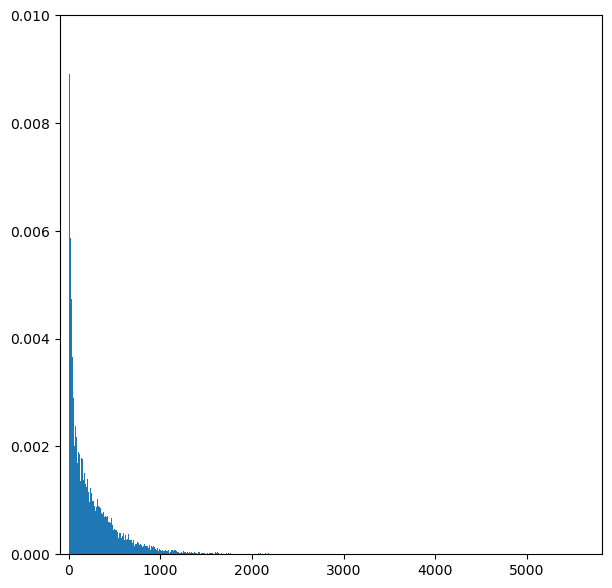

In [24]:
msno_counts = df_fulldata['msno'].value_counts()

print('Среднее количество данных о пользователе =', np.mean(msno_counts))
print('Медианное количество данных о пользователе =', np.median(msno_counts))
print('Максимальное количество данных о пользователе =', np.max(msno_counts))
print('Минимальное количество данных о пользователе =', np.min(msno_counts))

fig, ax = plt.subplots(figsize=(7, 7))
ax.hist(df_fulldata['msno'].value_counts(),bins=1000,density=True)
ax.set_xlim([-100, np.max(msno_counts)])
ax.set_ylim([0, 0.01])
plt.show()

Из полученных данных видно, что количество информации о пользователях сильно различается. Есть пользователи о которых практически нет информации, а есть те о которых её довольно много. Однако среднее и медианное значения количества информации о пользователях можно назвать достаточным, чтобы разрабатывать рекомендательную систему.

Матрицу корреляции строить не будем, поскольку большинство значений категориальные. Из-за этого она не даст нам особо никакой информации о зависимостях в данных.

Выясним, какие признаки оказывают наибольшее влияние на target. Для этого обучим классификатор RandomForest и извлечём из него информацию о влиянии признаков на target.

Разобьём данные на тренировочную и тестовую выборку, для определения качества класссификации. RandomForest будем тренировать на пользователях о которых достаточно много информации (больше 1000 записей).

In [25]:
filtered_msno = msno_counts[msno_counts > 1000].index

df_fitered = df_fulldata[df_fulldata['msno'].isin(filtered_msno)]

target = df_fitered['target']
train_data, test_data, train_labels, test_labels = train_test_split(df_fitered.drop(['target'], axis=1), target, test_size = 0.2)

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(1050994, 22)
(1050994,)
(262749, 22)
(262749,)


Создадим и обучим модель RandomForest.

In [26]:
RF = RandomForestClassifier()
RF.fit(train_data, train_labels)

RandomForestClassifier()

Метод score вернёт нам mean accuracy предсказаний модели.

In [27]:
RF_TrainScore = RF.score(train_data, train_labels)
RF_TrainScore

0.9999961940791289

На тренировочной выборке скор очень высокий, почти 100%.

In [28]:
RF_TestScore = RF.score(test_data, test_labels)
RF_TestScore

0.7174946431765677

На тестовой выборке скор заметно ниже (72%), чем на тренировочной. Но будем считать, что эта модель достаточно хорошо справляется с классификацией.

Извлечём из неё информацию о влиянии признаков на target.

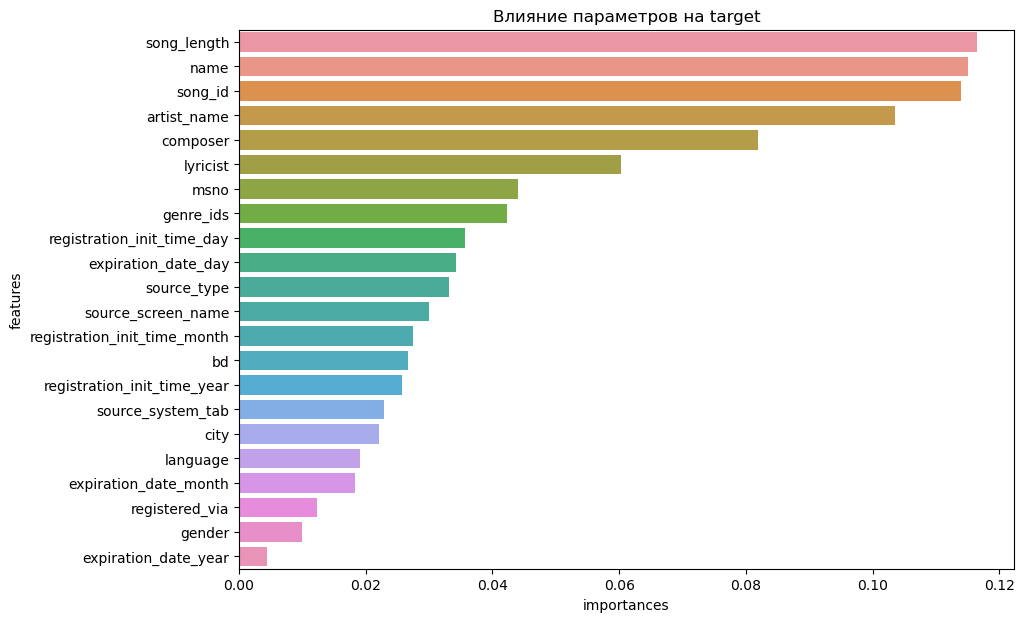

In [29]:
df_plot = pd.DataFrame({'features': train_data.columns,
                        'importances': RF.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

plt.figure(figsize=[10,7])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Влияние параметров на target')
plt.show()

Из графика выше видно, какие параметры влияют на target довольно сильно, а какие слабо.

Эту информацию можно использовать при построении рекомендательной системы, основанной на содержимом объектов рекомендации (Content-based recommendation system).

# Выбор модели для рекомендательной системы музыки.

Для выбора модели были изучены различные ресурсы, основным источником при выборе модели стала книга "System Design. Машинное обучение. Подготовка к сложному интервью | Али Аминиан, Алекс Сюй". В ней описан пример построения рекомендательной системы для видео, которая в некотором приблежении может быть схожа c аналогичной системой для музыки.

В книге предлагался вариант построения двух систем, на основе коллаборативной фильтрации и фильтрации на основе содержимого. Т.к. бльшинство признаков являются категориальными, построение рекомендательной системы на основе содержимого будет представлять непростую задачу. Поэтому для данного задания была выбрана коллаборативная система рекомендаций, котрая опирается на интуитивно понятную идею - "похожих пользователей интересуют похожие объекты".

Плюсами коллаборативной системы рекомендаций:
- Нетребовательность к вычислительным ресурсам.
- Система сможет предлагать пользователям новые объекты, которые они до этого не слушали, на основе предпочтений похожих пользователей.
- Для построения такой системы не требуется особое знание предметной области.

Однако минусами такой системы будут:
- Рекомендации для новых пользователей сложнее строить, т.к. по ним ещё нет особо никакой информации.
- Система будет плохо учитывать узкие интересы пользователей.

Систему рукомендаций будем строить на основе метода сингулярного разложения (SVD) матрицы обратной связи пользователь-объект.

# Подготовка данных для модели.

Для модели необходимо подготовить данные в виде матрицы обратной связи пользователь-объект. Колонками в этой матрице будут пользователи, а строками - треки. Значения в этой матрице будут представлять целевой параметр target.

In [30]:
df = df_fulldata[['msno', 'song_id', 'target']]

In [31]:
df.head(5)

,msno,song_id,target
0,8158,74679,1
1,17259,223479,1
2,17259,120758,1
3,17259,23707,1
4,8158,33308,1


Т.к. данных очень много, 30755 пользователей и 359966 треков, матрица обратной связи будет занимать очень много места, поэтому хранить её в dense виде не получится. Однако, т.к. эта матрица будет сильно разряжена (количество треков которые слушали пользователи на порядки меньше общего количества треков) будет выгодно хранить её в sparse виде.

In [32]:
rows, r_pos = np.unique(df.values[:, 1], return_inverse=True)
cols, c_pos = np.unique(df.values[:, 0], return_inverse=True)

In [33]:
user_item_sparse = sparse.csr_matrix((df.values[:, 2], (r_pos, c_pos)), dtype=float)

# Разработка модели.

Теперь разложим матрицу обратной связи с помощью метода SVD.

In [34]:
songs_vec, s, users_vec = svds(user_item_sparse, k=100)

В итоге мы получили два массива, songs_vec и users_vec, которые содержать в себе вектора длиной 100 (параметр k в функции svds), которые характеризуют некоторым образом треки и пользователей. С помощью скалярного произведения векторов пользователей и треков можно получать значение, которое некоторым образом будет отражающать релевантность трека для пользователя.

Для примера возьмём пользователя и выберим для него 20 самых релевантных трека, согласно получившейся модели. Релевантность, как уже говорилось, будем определять по скалярному произведению вектора пользователя на вектор трека.

In [35]:
relevance_list = []
msno = 6

for i in range(songs_vec.shape[0]):
    relevance_list.append(np.matmul(users_vec[:, msno], songs_vec[i]))

rec_list = np.argsort(relevance_list)[:-21:-1]

print('список song_id рекомендованных треков для пользователя с msno = ', msno, ':\n', rec_list, sep='')

список song_id рекомендованных треков для пользователя с msno = 6:
[110714 340555  28948 119157 274683 142338 127362 350076 240881  29794
 343047 129454 146487 281066 146965  31455 343593 177562 228489 101503]


In [36]:
target_for_rec_list = [user_item_sparse[:,msno].todense().tolist()[rec_list[i]][0] for i in range(len(rec_list))]

print('Target треков из рекомендательной выдачи для пользователя с msno =', msno)
for i in range(len(rec_list)):
    print('song_id:', rec_list[i], '\ttarget:', target_for_rec_list[i], sep='')

Target треков из рекомендательной выдачи для пользователя с msno = 6
song_id:110714	target:1.0
song_id:340555	target:1.0
song_id:28948	target:0.0
song_id:119157	target:1.0
song_id:274683	target:0.0
song_id:142338	target:0.0
song_id:127362	target:1.0
song_id:350076	target:0.0
song_id:240881	target:0.0
song_id:29794	target:0.0
song_id:343047	target:0.0
song_id:129454	target:0.0
song_id:146487	target:1.0
song_id:281066	target:1.0
song_id:146965	target:1.0
song_id:31455	target:0.0
song_id:343593	target:0.0
song_id:177562	target:1.0
song_id:228489	target:0.0
song_id:101503	target:0.0


# Подбор параметров модели.

Для более качественной рекомендации настроим параметр k у нашей модели, который отвечает за длину векторов для пользователя и трека.

Возьмём несколько k={150, 100, 50, 25, 15} и посмотрим на метрику NDSG@20 для 50 пользователей на каждом из них

In [37]:
def EvaluateModel(n_users_to_chek, rec_list_length, k):
    songs_vec, s, users_vec = svds(user_item_sparse, k=k)
    # Массив для хранения метрик NDSG@20 по рекомендательной выдаче для пользователей
    ndsgs = []

    for msno in range(n_users_to_chek):
        relevance_list = [] # Массив для хранения списка релевантности всех треков для пользователя
        
        for i in range(songs_vec.shape[0]):
            # Cчитаем релевантность скалярным произведением вектора пользователя и вектора трека и записываем её в массив
            relevance_list.append(np.matmul(users_vec[:, msno], songs_vec[i]))
        
        # Выбираем самые релевантные треки для пользователя и создаём массив с их song_id
        rec_list = np.argsort(relevance_list)[:-rec_list_length-1:-1]

        # Находим target для каждого трека в рекомендации пользователю
        target_rec_list = [user_item_sparse[:,msno].todense().tolist()[rec_list[i]][0] for i in range(rec_list_length)]

        # Считаем и записываем в массив NDSG@20 для полученного списка рекомендаций пользователю
        target_rec_list_sorted = sorted(target_rec_list, reverse=True)
        ndsgs.append(ndcg_score([target_rec_list_sorted], [target_rec_list]))
    # Возвращаем средний NDSG@20 по рекомендательным выдачам
    return np.mean(ndsgs)

In [38]:
print('Mean NDSG@20 for SVD with k = 150:', EvaluateModel(50, 20, 150))

Mean NDSG@20 for SVD with k = 150: 0.8252359552073059


In [39]:
print('Mean NDSG@20 for SVD with k = 100:', EvaluateModel(50, 20, 100))

Mean NDSG@20 for SVD with k = 100: 0.7942473272927935


In [40]:
print('Mean NDSG@20 for SVD with k = 50:', EvaluateModel(50, 20, 50))

Mean NDSG@20 for SVD with k = 50: 0.7743161978167956


In [41]:
print('Mean NDSG@20 for SVD with k = 25:', EvaluateModel(50, 20, 25))

Mean NDSG@20 for SVD with k = 25: 0.6796493508418796


In [42]:
print('Mean NDSG@20 for SVD with k = 15:', EvaluateModel(50, 20, 15))

Mean NDSG@20 for SVD with k = 15: 0.656040515902289


# Финальная оценка качества модели с помощью метрики NDSG@20.

Выберем модель с k=50, метрику для неё можно считать оптимальной, часть рекомендованных треков будет релевантно, а оставшаяся часть будет подобрана согласно вкусам похожих пользователей.

Найдём финальный скор нашей модели, посчитав средний скор по 100 пользователям.

In [44]:
print('Final score for SVD with k = 100:', EvaluateModel(100, 20, 50))

Final score for SVD with k = 100: 0.7231299994497722
